# Forecasting Customer Lifetime Value for Marketing Campaigns


## Introduction 

On the previous topic of this series, I explained [Why Uncertainty Matters](https://raphaeltamaki.github.io/raphaeltamaki/posts/Forecasting%20Customer%20Lifetime%20Value%20-%20Why%20Uncertainty%20Matters/) in for marketing, and how one should adapt the bidding to different degrees of Lifetime Value uncertainty and user acquisition response to the bid. In this part, we show how to obtain for a marketing campaign the customer Lifetime Value (LTV) and its uncertainty estimates by using XGBoost and PySTAN.

We will rely on the [Lifetime Value data from Kaggle](https://www.kaggle.com/datasets/baetulo/lifetime-value?resource=download) as the base for this exercise. This dataset is structured with the intent to predict the Lifetime Value of users using some short-term engagement information about them, which can be accomplished using a supervised algorithm such as XGBoost. 

However, when we are dealing with marketing campaigns, we are not as interested in the Lifetime Value of users that already got acquired as much as forecasting the Lifetime Value of the users to come. Afterall, from a (much simplified) tactic point of view, the only lever that User Acquisition can have in the profitability of the company is on correctly bidding on the users that are to come. 

But as these users don't yet exist, we don't have any short-term engagement information about them, just some audience targeting information, which can vary depending on the advertisement platform. For example, in Meta one can specifically target people based on interests, device (ex: iOS, Android), platform (ex: Instagram, Facebook, Messenger), and some other demographic information such as age and gender. Thus we need to obtain an estimate of the **expected LTV of the targetted population** by the marketing campaign instead of the LTV of specific users.




In this part, we closely replicate one way that a company can build LTV estimations to be used in marketing campaigns. It consists of 4 main steps:
1) **Data analysis**: he first step in our journey involves familiarizing ourselves with the data at hand. We will use the Lifetime Value data from Kaggle for this purpose. We will briefly examine this dataset to understand its structure and characteristics and shine a light on some of the prevalent hurdles we often encounter in LTV estimation
2) **User-Level LTV Estimation**: Our Kaggle dataset is organized at a user-level granularity. We will leverage the power of the XGBoost model to generate LTV predictions at this user level. This will create the base for the following steps.
3) **Grouping the user-level predictions into segment-level granularity**: But for marketing purposes, we need the LTV estimation to refer to a specific audience we are targeting (if it is an existing marketing campaign) or are interest to target (if the marketing campaign doesn't exists yet)
4) **Forecasting the segment-level LTV**: As we are interested in expected LTV of the population being targeted by our advertisement efforts, we want to have the estimation of **future** users of the population. So we need to estimate what the LTV is going to be, accounting for trends and seasonality for example, of the population while only having information about a sample of it.




## Data Analysis

We start by importing the required libraries, defining some global constants, and downloading the LTV dataset

#### Importing libraries and defining global constants

In [1]:
# nest_asyncio is needed for running pystan in a notebook
import nest_asyncio
nest_asyncio.apply()

In [2]:
import stan
import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


sns.set_style('whitegrid')
rng = np.random.default_rng(42)
PLOT_WITHD_INCHES = 20
PLOT_HEIGHT_INCHES = 10

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Downloading the data

We get the training dataset from the Lifetime Value dataset from Kaggle

In [3]:
!kaggle datasets download -d baetulo/lifetime-value

100%|██████████████████████████████████████| 10.5M/10.5M [00:00<00:00, 54.9MB/s]
100%|██████████████████████████████████████| 10.5M/10.5M [00:00<00:00, 54.2MB/s]


In [4]:
!unzip -j lifetime-value.zip 

Archive:  lifetime-value.zip
  inflating: test.csv                
  inflating: train.csv               


In [5]:
!rm lifetime-value.zip test.csv

In [6]:
data = pd.read_csv('train.csv')

In [7]:
data.head()

,product_type,user_id,join_date,hidden,product,STV,target,credit_card_level,is_lp,aff_type,is_cancelled,country_segment
0,type_ex,7.0,2018-12-01 00:01:45,0,product_1,8.25,8.25,standard,0,PPL,NaN,US
1,type_ex,20.0,2018-12-01 00:06:05,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
2,type_ex,22.0,2018-12-01 00:06:23,0,product_3,8.25,8.25,prepaid,0,PPL,NaN,US
3,type_ex,26.0,2018-12-01 00:07:12,0,product_2,8.25,8.25,standard,0,PPL,NaN,US
4,type_ex,59.0,2018-12-01 00:15:21,0,product_2,8.25,8.25,standard,0,PPL,NaN,Other Countries


#### Data exploration
We begin with exploratory data analysis (EDA) to get a sense of the variables in the dataset, their distributions, and relationships. This involves checking for missing data, examining correlations between variables, identifying potential outliers, and understanding the distribution of the LTV values. All these steps will provide valuable insights into the quality of the dataset and may hint towards any data cleaning or preprocessing that may be required.



Besides these typical areas,  Lifetime Value data at user-level often have the following properties:
1) **Zero-inflated**: if we are dealing with LTV of digital products, the digital products (especially mobile products) usually work on a freemium model. In this model, a user is free to use the product though with some limitations, like blocked features. This means that while users will try the product (or be interested interest enough to subscribe, download, participate in a free-trial, etc) few will actually pay for it.
2) **Highly-skewed**: even when we focus on the users who pay for a product, most will pay only a few times, in a subscription based products, or purchase a few low-value items, in In-App Purchase based products. However, there are highly-valuable users who subscrive for long time or that buy many expensive items, and
3) **Pareto distributed**: those high valuable users are often responsible for most of the revenue of a product.

Text(0.0, 1.0, "Distribution of user's Lifetime Value")

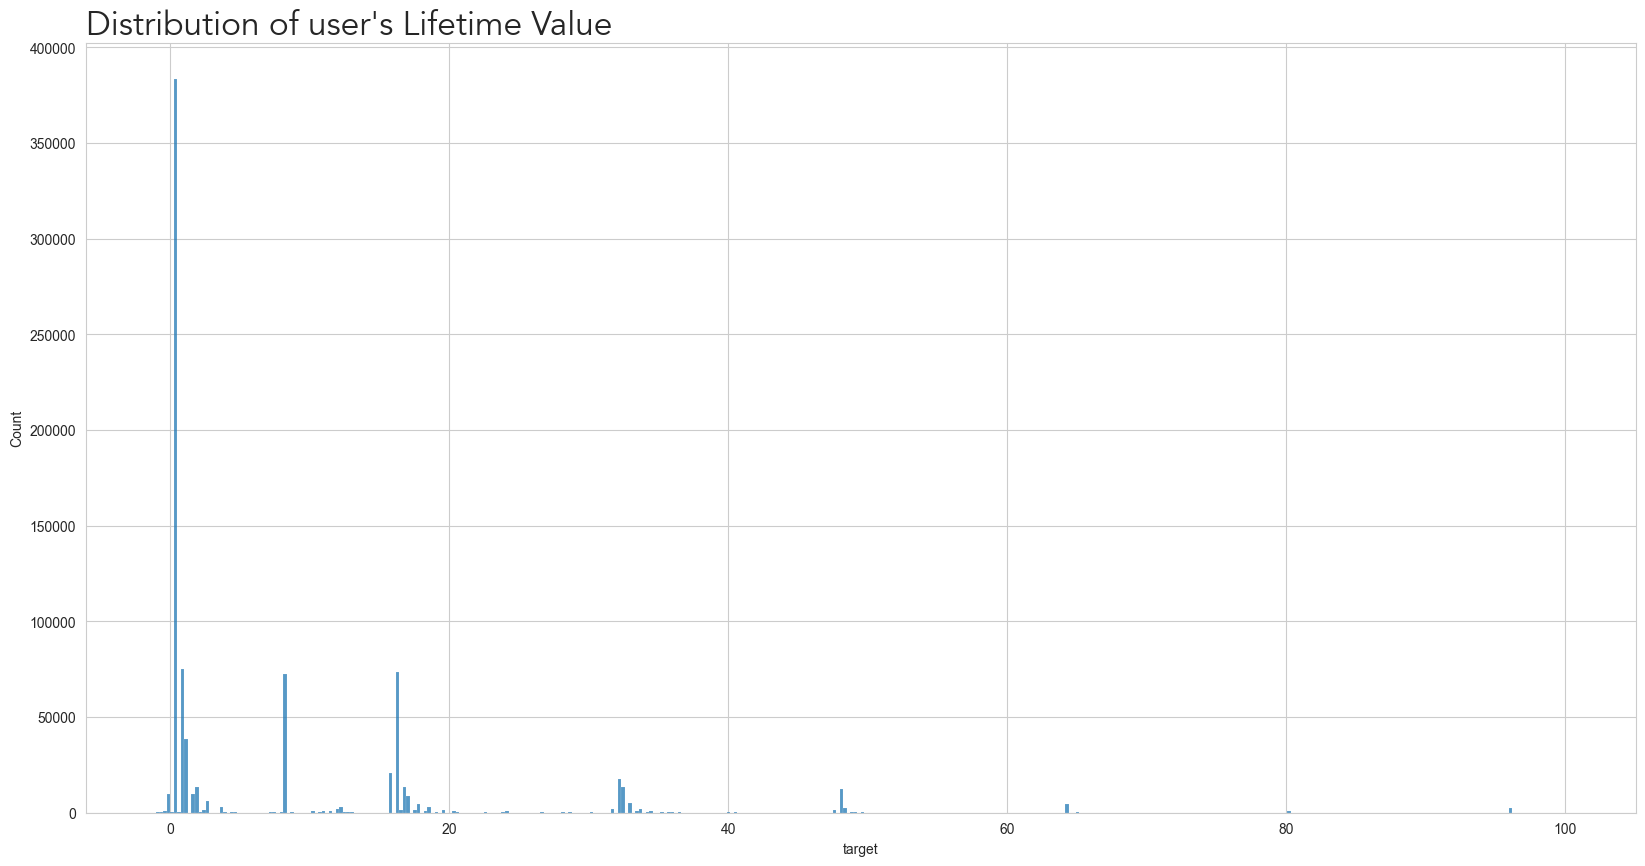

In [8]:
# Let's start looking at the distribution of LTV
grid = sns.histplot(data['target'], binrange=[-1, 100])
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)
plt.title(
    "Distribution of user's Lifetime Value", 
    font='Avenir', 
    fontsize=24, 
    loc='left')

From the distribution of the LTV, it is immediate that the 2 first properties are present: 
- Zero-inflated: most of the users are valued (almost) nothing, and 
- Highly-skewed: there are a few users that are worth much more than most, indicated by the presence of users valued close to $100.

Let's now see if the Pareto property is present as well:

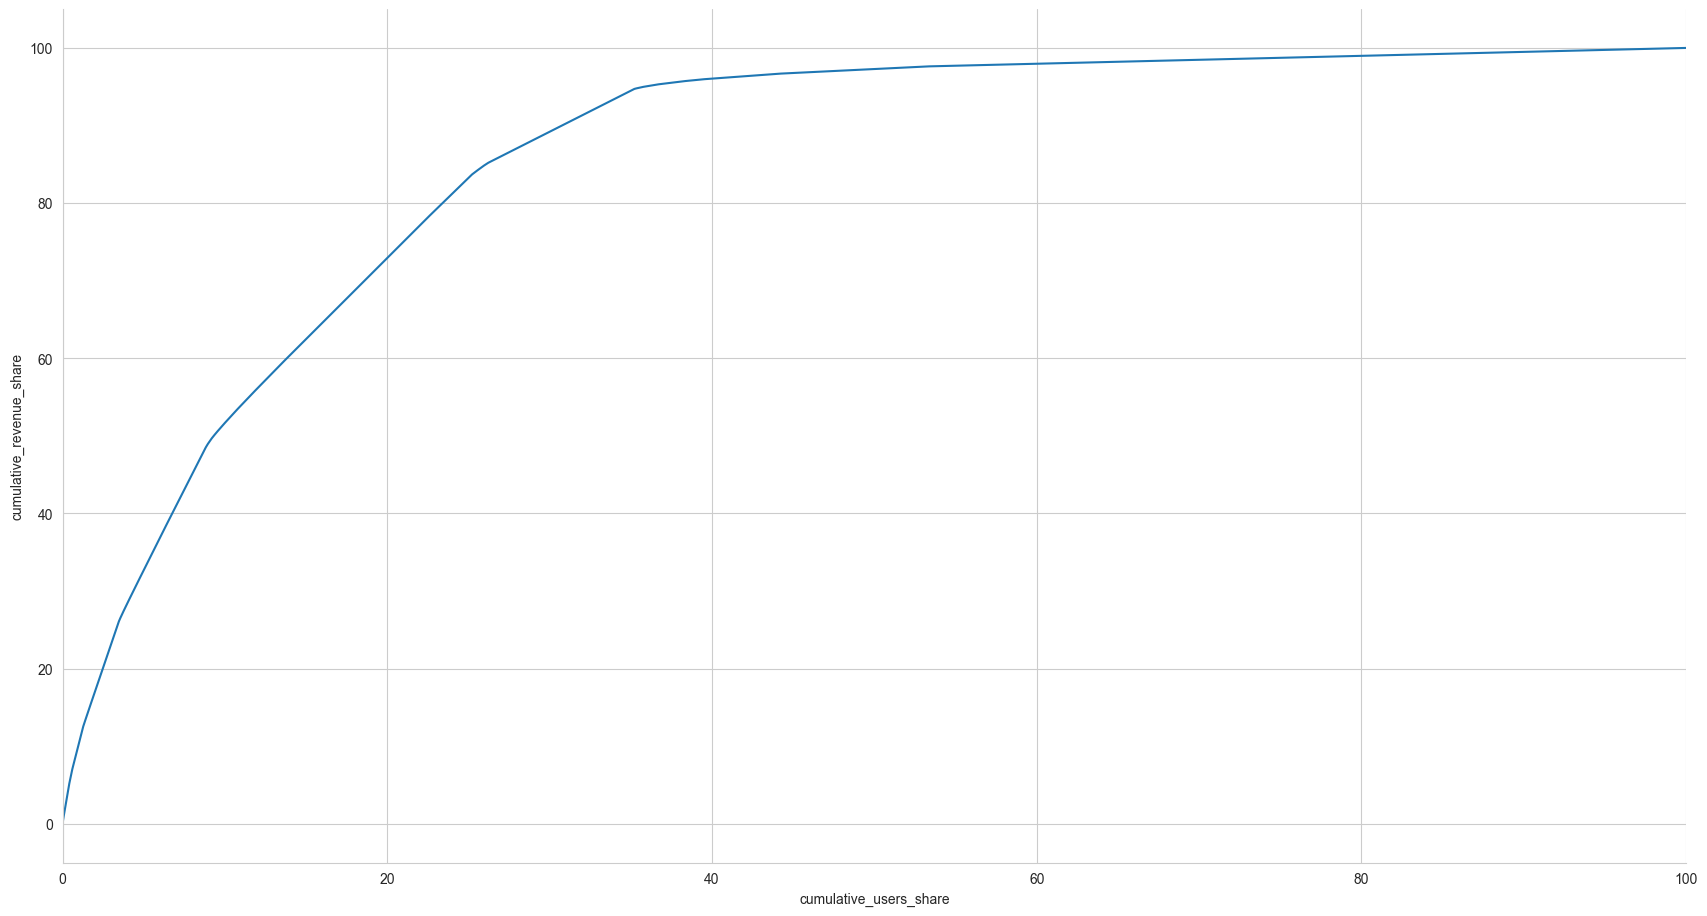

In [9]:
def summary(x):
    output = {}
    output['users'] = len(x['user_id'])
    output['revenue'] = np.sum(x['target'])
    return pd.Series(output)

pareto_data = data.query('target >= 0').groupby(['target']).apply(summary).reset_index()
pareto_data = pareto_data.sort_values(['target'], ascending=False)
pareto_data['cumulative_revenue_share'] = pareto_data['revenue'].cumsum() / pareto_data['revenue'].sum() * 100
pareto_data['cumulative_users_share'] = pareto_data['users'].cumsum() / pareto_data['users'].sum() * 100
pareto_data

grid = sns.relplot(pareto_data, x='cumulative_users_share', y='cumulative_revenue_share', kind='line', facet_kws={'xlim': [0, 100]})
grid.figure.set_size_inches(PLOT_WITHD_INCHES, PLOT_HEIGHT_INCHES)

By ordering in the users by descending LTV, we see that the 20% most valuable users are responsible for 76% of the revenue. This is almost a perfect Pareto relationship.

## 2- User-level LTV Prediction

Building lifetime value (LTV) estimations for marketing campaigns typically begins with estimating the LTV at a user-level for existing customers. Utilizing user-level data empowers us to take advantage of the unique interaction patterns of each individual user with the product, and the large volume of observations allows us to employ more complex models that can generalize well. It is generally recognized that tabular data, which is common in LTV prediction at the user-level granularity, [can be efficiently processed by tree-based boosting algorithms such as XGBoost](https://www.linkedin.com/pulse/present-future-kdd-cup-competition-outsiders-ron-bekkerman).

However, it's crucial to remember that time is a fundamental dimension in this problem. Therefore, we must incorporate it into our modeling approach. This means being mindful of potential temporal intersections between training and test data, particularly considering that our target data (LTV) originates much later in the 'future' compared to the time we collected the features for the model.

To put it into context, consider a situation where the lifetime period of our users is 63 days and we use features collected in the first 4 days since a user was 'born.' If the final day of the training period is January 1st, 2020, then the users in the test dataset must install the app 59 days (63-4) later. This way, we can ensure that no future temporal information that could be concealed in the features pollutes the evaluation of our model's accuracy.

As our ultimate aim is to forecast the LTV for users who don't yet exist, as they will be obtained via the marketing campaign, we introduce an additional period - which we term the validation period. During this period, we will project the average LTV of users in a specific population. For the sake of simplicity, let's define the population of interest as users in the US. By maintaining a meticulous approach that accounts for temporal dynamics, we can create reliable LTV predictions that support effective marketing strategies.

#### Separating the data in the 3 different periods

In [10]:
dates = pd.to_datetime(data['join_date'])

training_period = 60 # train for 60 days
training_start_date = np.min(dates)
training_end_date = training_start_date + timedelta(days=training_period)

# the test period for the model will of 63 days
test_start_date = training_end_date  + timedelta(days=63 - 4)
test_end_date = test_start_date  + timedelta(days=63)

# validation period will be used for the time-series
val_start_date = test_end_date  + timedelta(days=4)
val_end_date = np.max(dates)

print(f"Training period: From {training_start_date} to {training_end_date}")
print(f"Test period: From {test_start_date} to {test_end_date}")
print(f"Validation period: From {val_start_date} to {val_end_date}")

Training period: From 2018-12-01 00:00:04 to 2019-01-30 00:00:04
Test period: From 2019-03-30 00:00:04 to 2019-06-01 00:00:04
Validation period: From 2019-06-05 00:00:04 to 2019-06-30 23:59:56


#### Divide the dataset in Feature (X) and Target (y), and encode the categorical features so that it can be used directly by XGBoost

For simplicity, we encode the categorical features without any connection to the target, but ideally we encode the categories to some general meaning (ex: Country name to its GDP) or the target itself (target enconding)

In [11]:

y = data['target']
X = data.drop(['target', 'user_id', 'join_date'], axis=1)

def encode_categoricals(data: pd.DataFrame):
    from pandas.api.types import is_numeric_dtype
    non_numeric_cols = [
        column for column in list(data.columns) if not is_numeric_dtype(data[column])
    ]
    for column in non_numeric_cols:
        data[column] = data[column].astype("category").cat.codes
    return data

def date_filter(date: pd.Series, start_date, end_date):
    return (dates >= start_date) & (dates <= end_date)


X = encode_categoricals(X)


train_filter = date_filter(dates, training_start_date, training_end_date)
test_filter = date_filter(dates, test_start_date, test_end_date)
val_filter = date_filter(dates, val_start_date, val_end_date)

train_X = X[train_filter]
train_y = y[train_filter]


test_X = X[test_filter]
test_y = y[test_filter]

val_X = X[val_filter]
val_y = y[val_filter]

#### We then train a XGBRegressor with its default hyperparameters

Again, here we should do hyperparameter tuning, [especially on `n_estimator`, `max_depth`, `learning_rate`, `colsample_bytree`, `subsample`, and `min_child_weight`](https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter)

In [12]:
# We use a XGBRegressor with default hyperparameters
model = XGBRegressor()

# train base model
model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Now that we have the model trained, we can calculate its performance. We will approximate the uncertainty we care for the LTV of the users as only the associated error in the model predicting the LTV incorrectly. If we assume that the distribution of the error of our model on the trained data is going to be the same for future users, we can use the MSE of the model as an approximated measurement of the uncertaintly of the LTV.

The total uncertainty of the LTV of a group of users will have thus 2 components, one regarding the uncertainty whether the predictions are correct $Uncertainty_{Predictions}$, and another regarding how much the LTV of users vary $Uncertainty_{LTV}$

In [13]:
# Calculate the uncertainty of the predictions based on the error in the test data set
from sklearn.metrics import mean_squared_error
error_std = mean_squared_error(model.predict(test_X), test_y)

## 3- Grouping the user-level predictions into segment-level granularity

Now that we have a user-level model trained, we can generate predictions for recent users (who are in the Test Dataset) we need to group this users to represent the population we are targetting. While it isn't absolutely necessary to group up users in this way, transforming the data into a time-series makes it easier to take advantage of algorithms that take temporal information into account

We will thus group all the predictions of our users in the US (the population of interest for the marketing campaign), and later use it to forecast the expected LTV for the users we will acquire.

In [14]:
# Constants
def prepare_date(data: pd.DataFrame):
    data['date'] = (pd.to_datetime(data['join_date']) - training_start_date).dt.days
    return data

In [15]:
# group values per day, so that we have a time-series of the average LTV of this product
def summary(x):
    output = {}

    n_users = len(x['target'])
    output['users'] = n_users
    
    # Average and std LTV
    output['avg_target'] = np.mean(x['target'])
    output['sd_avg_value'] = np.std(x['target']) / np.sqrt(n_users) # stddev of the average, assuming normality
    
    # Average and std predictions
    output['avg_prediction'] = np.mean(x['prediction'])
    output['sd_prediction'] = np.std(x['prediction']) / np.sqrt(n_users) # stddev of the average, assuming normality
    output['true_sd_error'] = np.std(x['prediction'] - x['target']) / np.sqrt(n_users) # stddev of the average, assuming normality
    
    # we set the error variance to be that of what we observed during the train period.
    # As this is related to the error at user level, we have to divide py the square root of the number of users
    output['estimated_sd_error'] = error_std / np.sqrt(n_users)
    
    # we assume that there is no correlation between the prediction error and the prediction itself
    output['total_sd_prediction'] = np.sqrt(output['sd_prediction']**2 + output['estimated_sd_error']**2)
    return pd.Series(output)


In [16]:
# Create the time-series data for the Test period, which represent the period of time 
# we consider valid to train our time-series model

test_time_series_data = test_X.query('country_segment == "13"') # country code for US is 13
test_time_series_data['date'] = (dates[test_filter] - test_start_date).dt.days
test_time_series_data['prediction'] = model.predict(test_X)
test_time_series_data['target'] = test_y

test_time_series_data = test_time_series_data.groupby(['date']).apply(lambda x: summary(x)).reset_index()
test_time_series_data.head()

/var/folders/_1/c79n_fvs2bx1dwv8qf9wj04h0000gn/T/ipykernel_1565/2938690167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_time_series_data['date'] = (dates[test_filter] - test_start_date).dt.days
/var/folders/_1/c79n_fvs2bx1dwv8qf9wj04h0000gn/T/ipykernel_1565/2938690167.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_time_series_data['prediction'] = model.predict(test_X)
/var/folders/_1/c79n_fvs2bx1dwv8qf9wj04h0000gn/T/ipykernel_1565/2938690167.py:7: SettingWithCopyWarning: 
A value is tr

,date,users,avg_target,sd_avg_value,avg_prediction,sd_prediction,true_sd_error,estimated_sd_error,total_sd_prediction
0,0,4639.0,6.323679,0.227428,6.735502,0.126238,0.196348,2.404214,2.407526
1,1,5045.0,6.715325,0.220810,6.966258,0.128640,0.189552,2.305445,2.309031
2,2,4740.0,6.823155,0.216144,6.902818,0.130749,0.180993,2.378461,2.382052
3,3,4216.0,7.032902,0.255530,7.281071,0.150984,0.211738,2.521941,2.526457
4,4,4289.0,6.619117,0.235460,6.919528,0.138276,0.197603,2.500387,2.504208


<Axes: xlabel='date', ylabel='avg_prediction'>

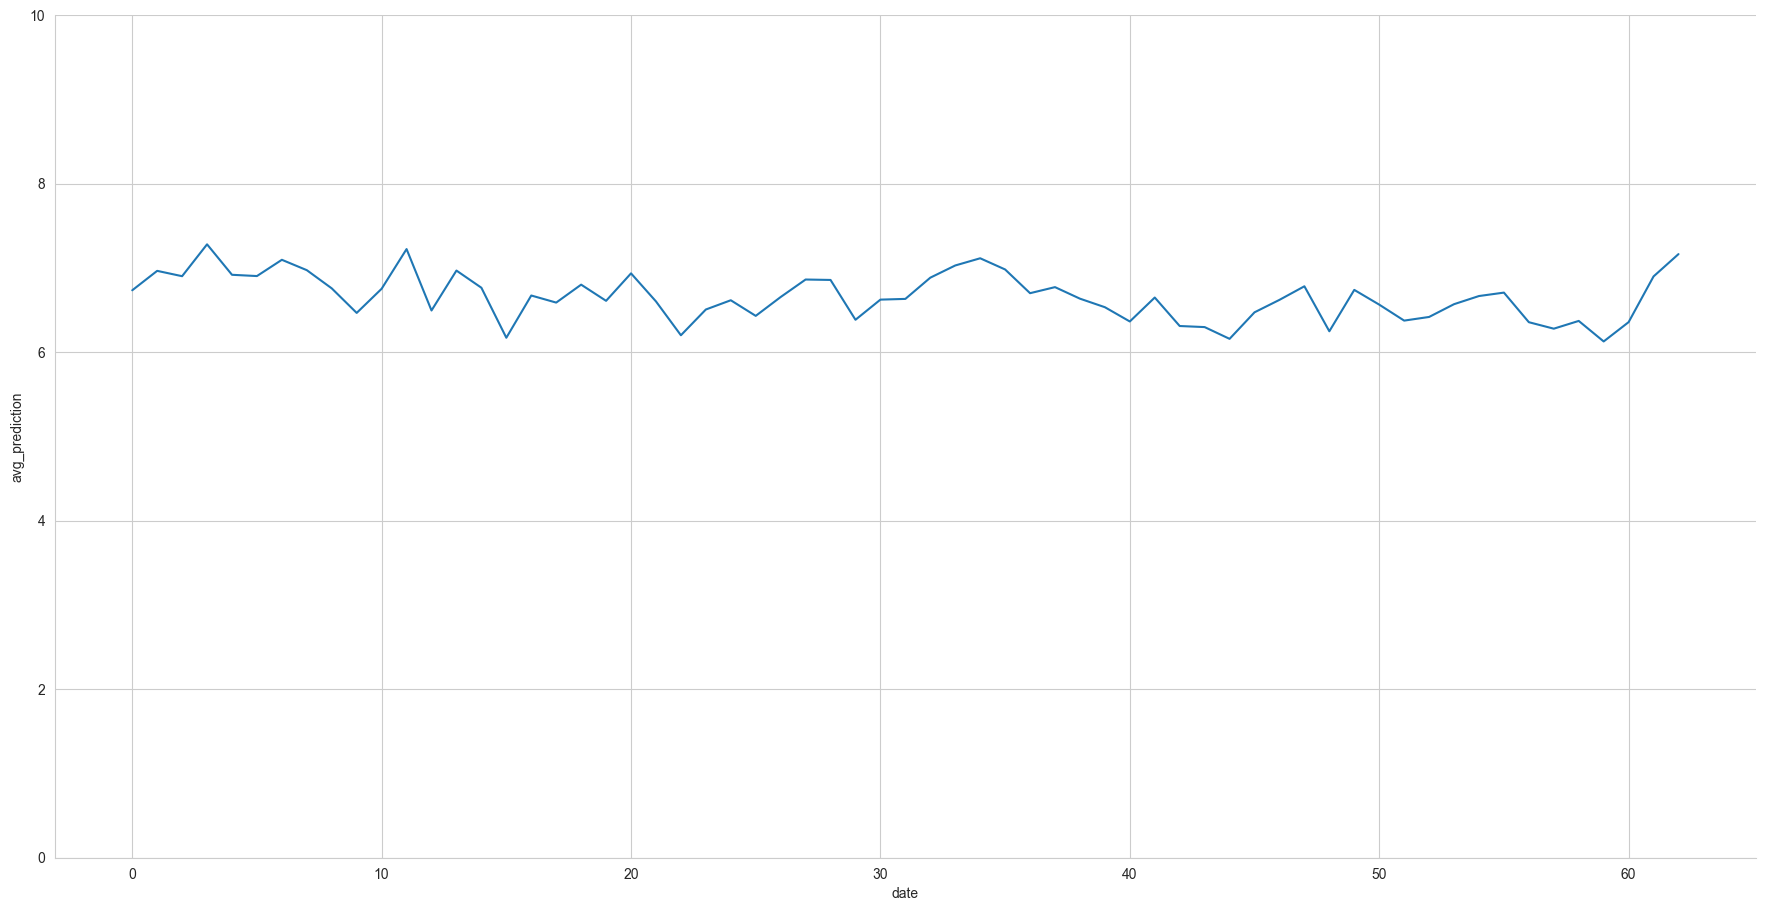

In [17]:
g = sns.relplot(test_time_series_data, x='date', y='avg_prediction', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)
g.ax

## 4- Forecasting the segment-level LTV (using PySTAN)

With the LTV prediction for the segment of interest ready, we just need to forecast the LTV for future users of this segment. For this objective, we will use PySTAN to model the LTV as a Gaussian Random Walk. The main argument to model this as Gaussian Random Walk are
- it captures the idea that more recent information is more informative of future behavior, which is similar to usial an Exponential Moving Average.
-  but in contrast to the Exponential Moving Average, the Gaussian Random Walk captures the fact that some days are more informative than others. For example, if a segment has for some period a very low number of users (ex: 10) compared to the the usual volume (ex: 1000), the model should take the observed value with a bit pinch of salt, since the variance of the average predicted LTV is going to be greater simply because of the lower volume. (Remember that Var(E(X)) = Var(X) / sqrt(N) for a normal distribution).

To implement a Gaussian Random Walk in PySTAN we first need to
1) define the stan model
2) prepare the data for stan (it has to be passed as a dict)
3) train the model (can take a long time, since it is estimate a distribution for each point)
4) visualize results

### 4.1- Define the Stan Model

For this case, the Stan model is pretty straightforward. The Stan model is divided into 'blocks' defined by the brackets "{}". There are mainly 3 building blocks
- **data**: which defines Stan values that are inputs and will be used to estimate the parameters of the model
- **parameters**: as you would expect by the name, are the parameters of the model you want to build
- **model**: is where you describe how the data and the parameters are connected

In this example, we just have 2 parameters that we want to estimate:
- `nu`, which contains the distribution of the expected LTV of each day
- `random_walk_stddev`, which estimates the variance of the random walk and needs to be positive

As this is a bayesian model, we always need to define priors for our variables:
- for `random_walk_stddev`, we define a fairly weak prior following a Cauchy distribution with parameters 0 and 2
- for the first element of the random walk `nu`, we also define a week prior following a normal distribution with mean 6 and standard deviation 3. Notice that this is the prior for the random walk, not for the LTV distribution of each day
- the LTV of each day is defined on the last line, which we state is normally distributed, with the expected value being the same as our random walk on a specific day and with standard deviation being what we measured to be based on the user-level LTV and the number of users on each day

In [18]:
time_series_model = """
data {
  int<lower=0> N;
  vector[N] sampled_value;
  vector[N] sampling_stddev;
}
parameters {
    vector[N] nu; //The random-walking expected value
    real<lower=0.001> random_walk_stddev; // Standard deviation of random walk
}

model {
    random_walk_stddev ~ cauchy(0, 2); // Define the prior for the random walk stddev
    nu[1] ~ normal(6, 3); // initalize at a point with a fairly weak prior, but far from the truth, just to see convergence
    for (n in 2:N) {
        nu[n] ~ normal(nu[n-1], random_walk_stddev);
    }
    sampled_value ~ normal(nu, sampling_stddev);
}
"""

### 4.2- Prepare data for PySTAN

PySTAN requires that the data be passed as a dictionary, with the keys matching the names defined in the `data` block of the model. In addition, the values on the keys should match the format and variable type defined by the model, which means that the value `N` needs to be a single numeric value instead of a list/array

In [19]:
stan_format_data = {}
stan_format_data['ts']= list(test_time_series_data['date'].values)
stan_format_data['sampled_value']= list(test_time_series_data['avg_prediction'].values)
stan_format_data['sampling_stddev']= list(test_time_series_data['total_sd_prediction'].values)
stan_format_data['N']= test_time_series_data.shape[0]

### 4.3- Train the model

In [20]:
# train the model
start_time = time.time()
# pass the model to STAN (doesn't 'train the model' per say)
posterior = stan.build(time_series_model, data=stan_format_data)
# sample (is the actually 'fit')
fit = posterior.sample(num_chains=4, num_samples=1000)
print(f"Training the model took {time.time() - start_time} seconds")

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:   2% (200/8000)
Sampling:   5% (400/8000)
Sampling:  10% (800/8000)
Sampling:  15% (1200/8000)
Sampling:  20% (1600/8000)
Sampling:  26% (2100/8000)
Sampling:  29% (2300/8000)
Sampling:  35% (2800/8000)
Sampling:  52% (4200/8000)
Sampling:  69% (5500/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
 

Training the model took 10.852032661437988 seconds


### 4.4- Visualize predictions

We extract the estimated parameters from the model as a Pandas data frame.
However, in the true fashion of statistical modeling, what we get is not a single value for each parameter. Instead, each row represents a sample from our simulation

As we are (for now) interested only in the expected value of the LTV for each day, we
- only select the columns starting with 'nu.'. Vector parameters in PySTAN have the positions of the elements explicit after a "."
- we calculate the mean (and standard deviation) for each day, then finally
- we combine with the original data to obtain a visualization of how our model fared

In [21]:
model_data = fit.to_frame()  # get the samples from the estimated distribution of each parameter to a pandas DF
model_data.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,nu.1,nu.2,nu.3,...,nu.55,nu.56,nu.57,nu.58,nu.59,nu.60,nu.61,nu.62,nu.63,random_walk_stddev
draws,,,,,,,,,,,,,,,,,,,,,
0,243.248862,0.975374,0.005400,7.0,127.0,0.0,-217.725294,5.905877,5.903037,5.905134,...,5.913138,5.904469,5.900042,5.892362,5.891465,5.900651,5.898936,5.917396,5.921576,0.010718
1,90.832594,0.964157,0.043114,6.0,127.0,0.0,-59.892197,6.373705,6.360289,6.517213,...,6.189371,6.366772,6.336089,6.336108,6.287105,6.509657,6.557374,6.501992,6.608029,0.138535
2,110.754029,0.826686,0.048811,5.0,31.0,0.0,-83.456408,6.372351,6.357777,6.301246,...,6.000944,5.904071,5.855949,5.896517,5.899362,5.912371,6.018529,5.932177,5.989197,0.102801
3,131.102039,0.868984,0.048564,4.0,31.0,0.0,-104.002645,7.155215,7.115687,6.992612,...,6.713900,6.750494,6.699323,6.553804,6.610047,6.609527,6.792441,6.732738,6.643164,0.077290
4,238.489225,0.946521,0.005400,7.0,255.0,0.0,-207.021042,5.917329,5.911498,5.924998,...,5.923435,5.927940,5.939866,5.972252,5.977284,5.998974,6.016202,6.008741,6.006281,0.012640


In [22]:
# Get the average and stddev of the estimates on each day (each one of the nu.{NUMBER})
columns_ = model_data.reset_index().columns
columns_ = [x for x in columns_ if 'nu' in x]
simp_model_data = model_data[columns_]
avgs = np.mean(simp_model_data, axis=0).values

plot_data = pd.DataFrame(
    {
        'date': test_time_series_data['date'],
        'estimated_value': avgs
    },
    columns=['date', 'estimated_value']
)

# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(test_time_series_data, plot_data, on='date')
# create a moving average as a reference
plot_data['moving_average'] = plot_data.sort_values('date')['avg_prediction'].rolling(window=7).mean()
plot_data = plot_data[['date', 'estimated_value', 'avg_prediction', 'moving_average']]
plot_data = pd.melt(plot_data, id_vars='date', value_vars=['estimated_value', 'avg_prediction', 'moving_average'])

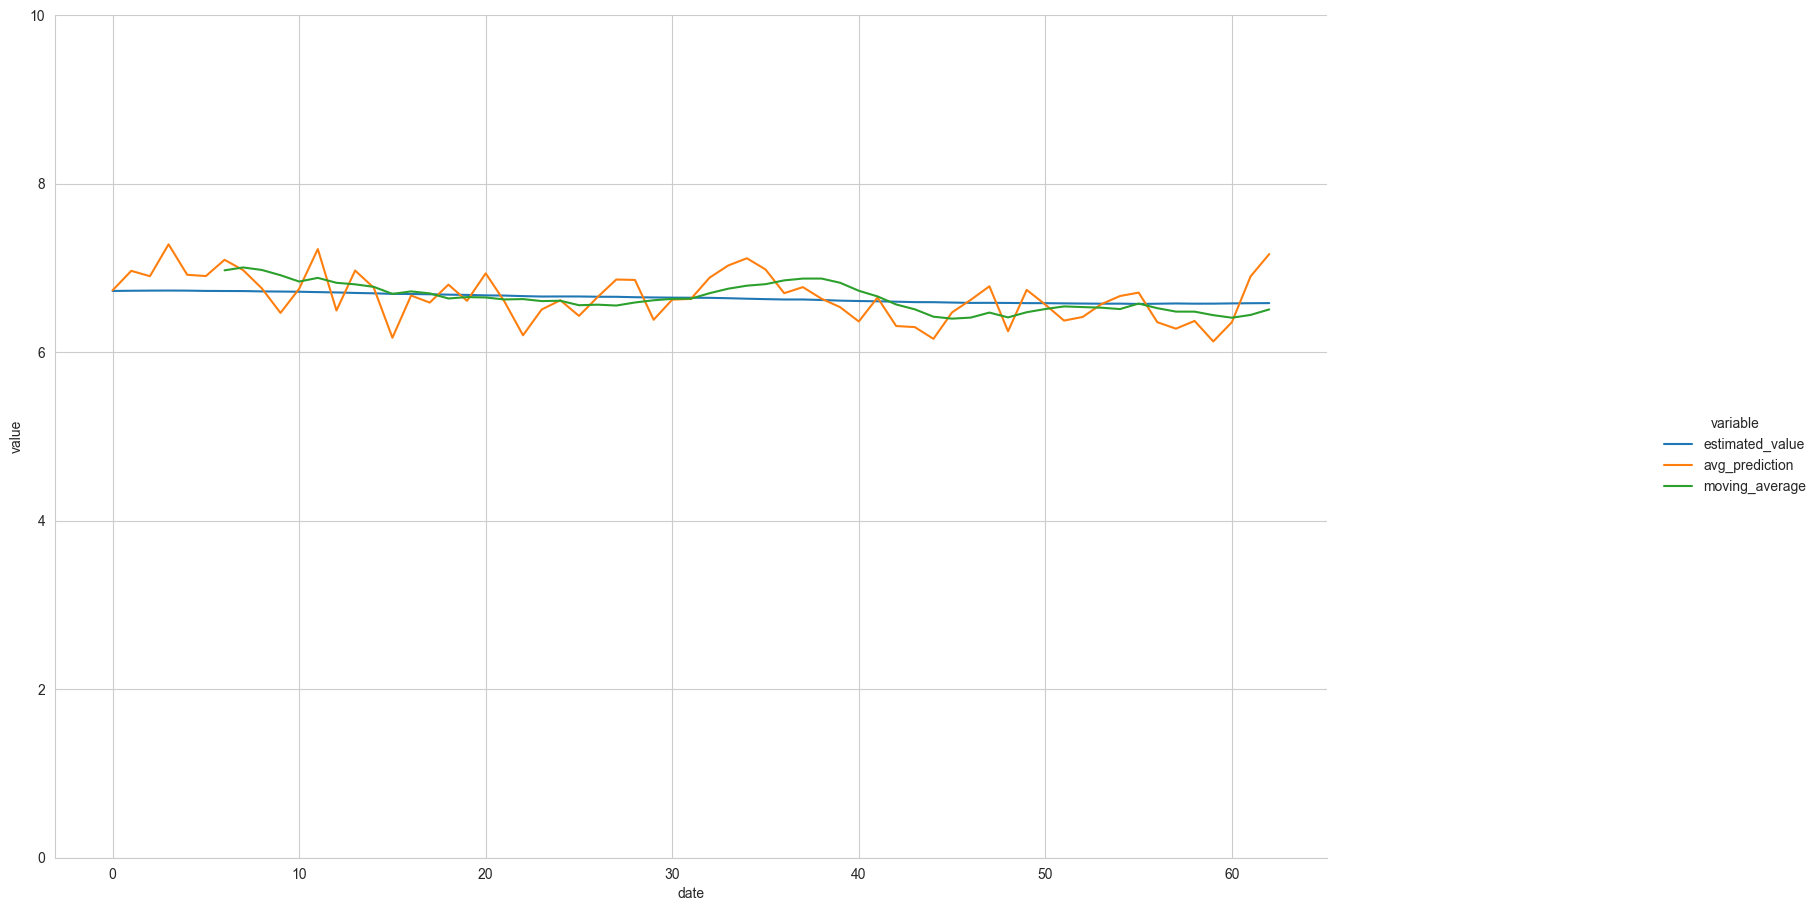

In [23]:
g = sns.relplot(plot_data, x='date', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)

You see here that the algorithm found the value for the random walk variance that makes the data fit the best. In this case, as there isn't much variation over time and the data does appear to vary over a constant value, the random walk variance was estimated to be very small.

Now let's observe how it performed on the validation period:

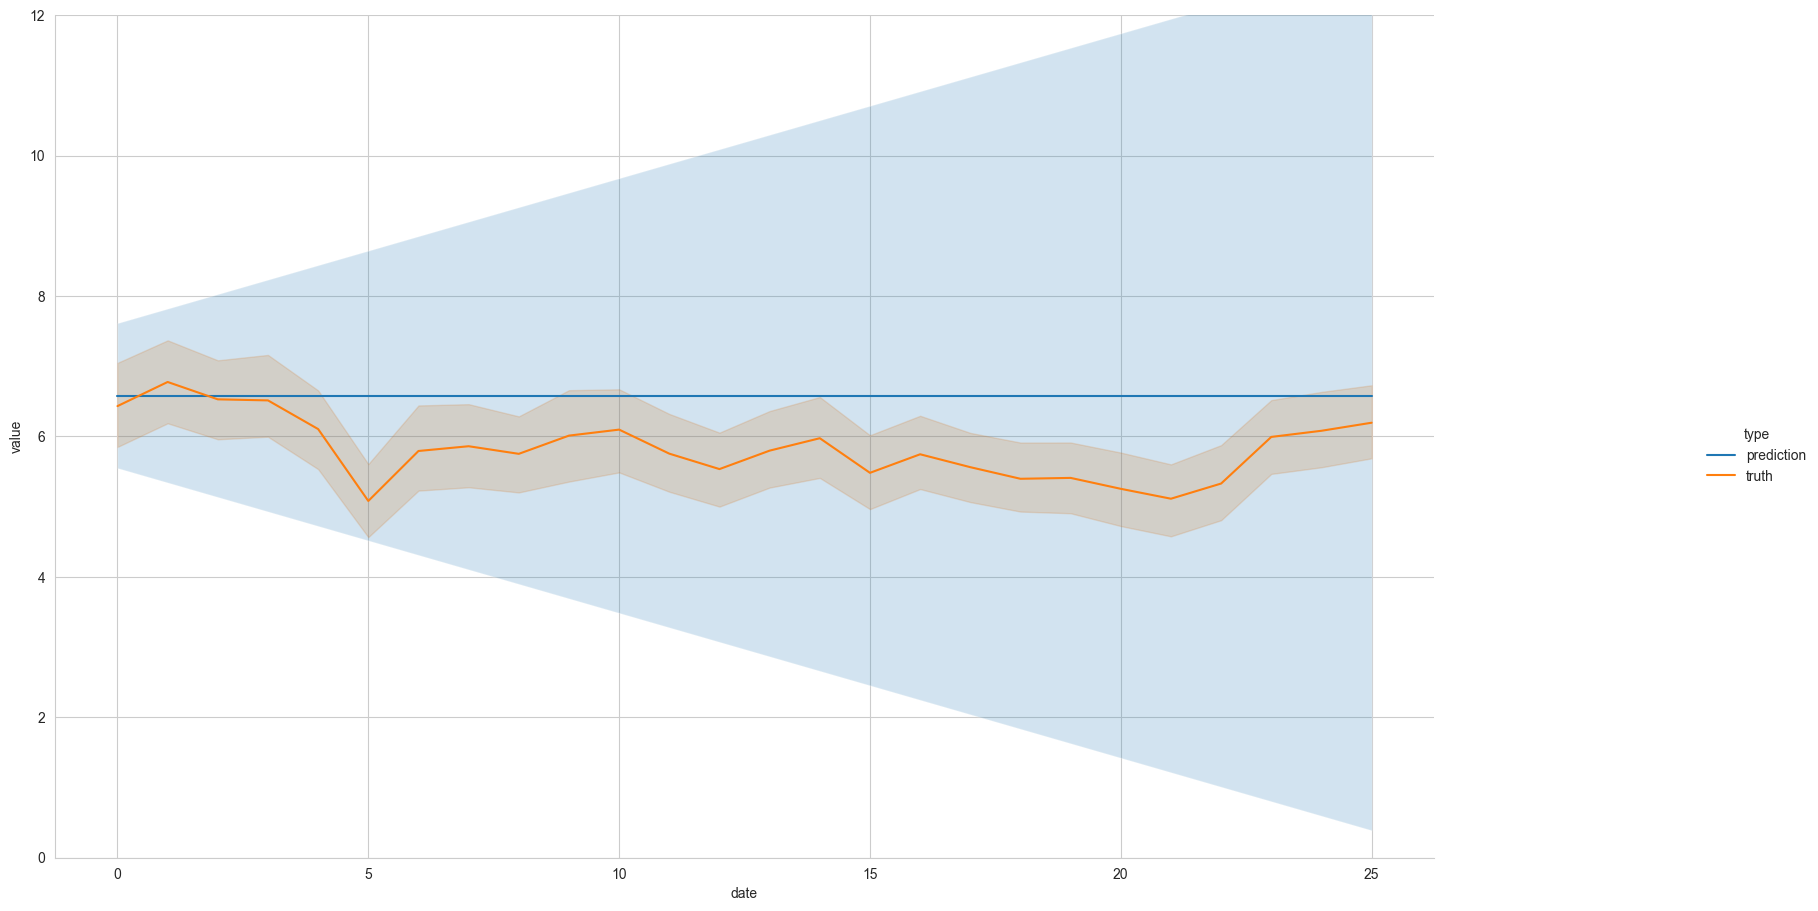

In [24]:
random_walk_std = model_data['random_walk_stddev'].mean()

# Obtain the 'prediction' for the next period, which is simply the last predicted point in a Random Walk
val_days = (val_end_date - val_start_date).days
output = pd.DataFrame(
    {
        "date": np.linspace(0, val_days, val_days),
        "value": np.ones(val_days) * avgs[-1]
    }
)
output['type'] = 'prediction'

# Extact the time-series for the validation period
val_time_series_data = pd.DataFrame({
    'date': ((dates[val_filter])[val_X['country_segment'] == 13] - val_start_date).dt.days,
    'value': val_y[val_X['country_segment'] == 13]
})
val_time_series_data['type'] = 'truth'


comparison_date = pd.concat([output, val_time_series_data])

g = sns.relplot(comparison_date, x='date', y='value', hue='type', kind='line', facet_kws={'ylim': [0, 12]})
g.figure.set_size_inches(20, 10)

# add the 95% confidence region
# the last point in the test period is actually 4 days before the first day on the validation period
output['low'] = output['value'] - 1.96 * random_walk_std * (4 + 1 + output['date'])
output['high'] = output['value'] + 1.96 * random_walk_std * (4 + 1 + output['date'])
plt.fill_between(output['date'], output['low'], output['high'], alpha=0.2)
plt.show()

## Observation: A critical point to be aware of when using PySTAN for forecasting

While both models performed well for our purpose, it is important to know that all points in the Gaussian Random Walk modeled by PySTAN use **all** of the data points of the time series when 'fitting'. **This means that all the estimated values but the very last point cannot be used to estimate the performance of the model.** If we need to evaluate the performance of the model for each day, we have to train N models, one for each day, repeating the whole process

This happens because, in essence, this model of ours is a hierarchical multi-level gaussian model, in which each 'level' is a date. In a hierarchical multi-level model each layer/level of the model impacts the estimated value of its preceding and following layers.

We demonstrate this point by changing the data to simulate a step signal: it is constant for half of the time after which it immediately changes to a different constant value.

In [25]:
# Change the data to be step-like 
# Define the data to be a step
n_days = 140
before_step_days = 70
after_step_days = n_days - before_step_days
before_value = 9
after_value = 2

step_time_series_data = pd.DataFrame(
    {
        'join_date': np.linspace(1, n_days, num=n_days),
        'sampled_value': np.concatenate([np.full(before_step_days, before_value), np.full(after_step_days, after_value)]),
        'sampling_stddev': np.full(n_days, 0.1)
    }
)

step_format_data = {}
step_format_data['joined_date']= list(step_time_series_data['join_date'].values)
step_format_data['sampled_value']= list(step_time_series_data['sampled_value'].values)
step_format_data['sampling_stddev']= list(np.sqrt(step_time_series_data['sampling_stddev'].values))
step_format_data['N']= step_time_series_data.shape[0]

In [26]:
# Create a replica of the last model and train it
step_model = time_series_model

# train the model
start_time = time.time()
# pass the model to STAN (doesn't 'train the model' per say)
posterior = stan.build(step_model, data=step_format_data)
# sample (is the actually 'fit')
fit = posterior.sample(num_chains=4, num_samples=1000)
print(f"Training the model took {time.time() - start_time} seconds")

Building: found in cache, done.
Messages from stanc:
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!


Training the model took 2.732028007507324 seconds


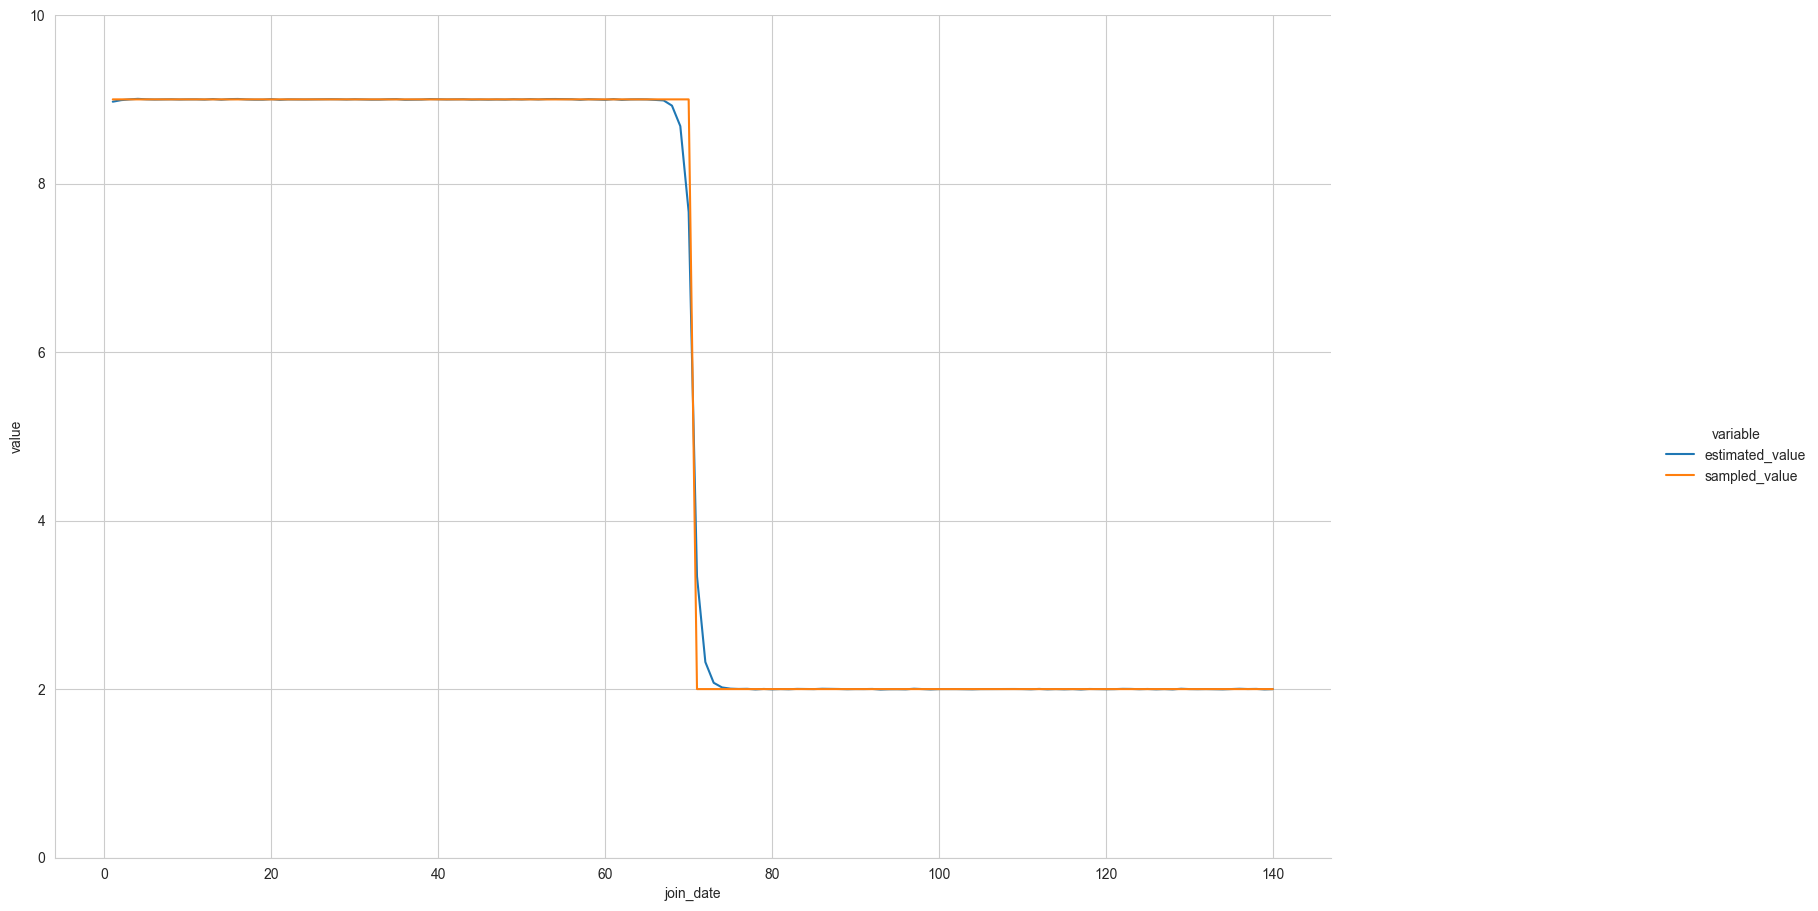

In [27]:
model_data = fit.to_frame()  # get the samples from the estimated distribution of each parameter to a pandas DF

# Get the average and stddev of the estimates on each day
columns_ = model_data.reset_index().columns
columns_ = [x for x in columns_ if 'nu' in x]
simp_model_data = model_data[columns_]
avgs = np.mean(simp_model_data, axis=0).values
stddevs = np.std(simp_model_data, axis=0).values
simp_model_data = pd.DataFrame(
    {
        'join_date': step_time_series_data['join_date'],
        'estimated_value': avgs,
        'stddev': stddevs
    },
    columns=['join_date', 'estimated_value', 'stddev']
)

# create a data to plot the estimated value, the observed value, and the 'true' value
plot_data = pd.merge(step_time_series_data, simp_model_data, on='join_date')
plot_data = plot_data[['join_date', 'estimated_value', 'sampled_value']]
plot_data = pd.melt(plot_data, id_vars='join_date', value_vars=['estimated_value', 'sampled_value'])

g = sns.relplot(plot_data, x='join_date', y='value', hue='variable', kind='line', facet_kws={'ylim': [0, 10]})
g.figure.set_size_inches(20, 10)